# Lab8: Model Predictive Control

This lab is modified from [notebook by Prof. Richard Murray](https://colab.research.google.com/drive/1AufRjpbdKcOEoWO5NEiczF3C8Rc4JuTL)

This lab introduces Model Predictive Control (MPC). We will start by implementing a continuous-time MPC for a double integrator system and compare its performance against a standard LQR controller. We will then explore a discrete-time MPC implementation for the same system.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
try:
  import control as ctl
  print("python-control", ctl.__version__)
except ImportError:
  !pip install control
  import control as ctl
import control.optimal as opt
import control.flatsys as fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.3/578.3 kB 5.5 MB/s eta 0:00:00


## System definition for Double Integrator

To illustrate the implementation of a model predictive controller, we consider a linear system corresponding to a double integrator with bounded input:

$$
  \dot x = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} x + \begin{bmatrix} 0 \\ 1 \end{bmatrix} \text{clip}(u)
  \qquad\text{where}\qquad
  \text{clip}(u) = \begin{cases}
    -1 & u < -1, \\
    u & -1 \leq u \leq 1, \\
    1 & u > 1.
  \end{cases}
$$

We implement a model predictive controller by choosing

$$
  Q_x = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}, \qquad
  Q_u = \begin{bmatrix} 1 \end{bmatrix}, \qquad
  P_1 = \begin{bmatrix} 0.1 & 0 \\ 0 & 0.1 \end{bmatrix}.
$$



The system can be defined as follows.

In [2]:
def doubleint_update(t, x, u, params):
    # Get the parameters
    lb = params.get('lb', -1)
    ub = params.get('ub', 1)
    assert lb < ub

    # bound the input
    u_clip = np.clip(u, lb, ub)

    return np.array([x[1], u_clip[0]])

proc = ctl.nlsys(
    doubleint_update, None, name="double integrator",
    inputs = ['u'], outputs=['x[0]', 'x[1]'], states=2)

## Task 1: Continous time MPC

We will first implement a continous time MPC for the system.

### Problem Setup

To define a MPC controller, we first need to create an optimal control problem (using the `OptimalControlProblem` class) and then use the `compute_trajectory` method to solve for the trajectory from the current state. This `compute_trajectory` method is the same as the `ocp_solve` we played with in Lab 7.

We start by defining the cost functions, which consists of a trajectory cost (or integral cost) and a terminal cost:

In [3]:
Qx = np.diag([1, 0])            # weight matrix for state cost
Qu = np.diag([1])               # weight matrix for input cost
traj_cost=opt.quadratic_cost(proc, Qx, Qu)

P1 = np.diag([0.1, 0.1])        # weight matrix for terminal cost
term_cost = opt.quadratic_cost(proc, P1, None)

We also set up a set of constraints that correspond to the fact that the input should be less than 1.  This can be done using either the [`input_range_constraint`](https://python-control.readthedocs.io/en/0.9.3.post2/generated/control.optimal.input_range_constraint.html) function or the [`input_poly_constraint`](https://python-control.readthedocs.io/en/0.9.3.post2/generated/control.optimal.input_poly_constraint.html) function.

In [4]:
traj_constraints = opt.input_range_constraint(proc, -1, 1)
# traj_constraints = opt.input_poly_constraint(
#     proc, np.array([[1], [-1]]),  np.array([1, 1]))

We define the horizon for evaluating finite-time, optimal control by setting up a set of time points across the designed horizon.  The input will be computed at each time point.

In [5]:
Th = 5  # horizon length: this is how far ahead we plan for each repetition of the MPC
timepts = np.linspace(0, Th, 11, endpoint=True)
print(timepts)

[0.  0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]


Finally, we define the optimal control problem that we want to solve (without actually solving it).

In [6]:
# Set up the optimal control problem
ocp = opt.OptimalControlProblem(
    proc, timepts, traj_cost,
    terminal_cost=term_cost,
    trajectory_constraints=traj_constraints,
    # terminal_constraints=term_constraints,
)

To make sure that the problem is properly defined, we first solve the problem for a specific initial condition.  We also compare the amount of time required to solve the problem from a "cold start" (no initial guess) versus a "warm start" (use the previous solution, shifted forward on point in time).

In [7]:
X0 = np.array([1, 1])

start_time = time.process_time()
res = ocp.compute_trajectory(X0, initial_guess=0, return_states=True)
stop_time = time.process_time()
print(f'* Cold start: {stop_time-start_time:.3} sec')

# Resolve using previous solution (shifted forward) as initial guess to compare timing
start_time = time.process_time()
u = res.inputs
u_shift = np.hstack([u[:, 1:], u[:, -1:]])
ocp.compute_trajectory(X0, initial_guess=u_shift, print_summary=False)
stop_time = time.process_time()
print(f'* Warm start: {stop_time-start_time:.3} sec')

Summary statistics:
* Cost function calls: 238
* Constraint calls: 280
* System simulations: 2
* Final cost: 6.023383015581568
* Cold start: 0.329 sec
* Warm start: 0.449 sec


In this case the timing is not that different since the system is very simple.

Plotting the result, we see that the solution is properly computed.

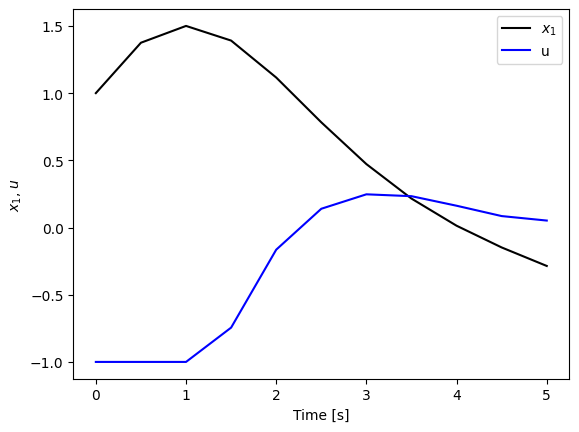

In [8]:
plt.plot(res.time, res.states[0], 'k-', label='$x_1$')
plt.plot(res.time, res.inputs[0], 'b-', label='u')
plt.xlabel('Time [s]')
plt.ylabel('$x_1$, $u$')
plt.legend();

### MPC controller

After setting up the problem, now we can implement the MPC controller using a function that we can use with different versions of the problem.

In [9]:
def run_mpc(proc, ocp, x0, tf, print_summary=False, verbose=False):
    """Run a MPC simulation."""
    x = x0
    t_cur = 0.0 # current time

    # Lists to store the full trajectory
    time_hist, states_hist, inputs_hist = [np.array([t_cur])], [x0[:, np.newaxis]], []
    first_iteration = True

    # MPC loop
    while t_cur < tf:
        # Compute the optimal trajectory over the horizon
        start_time = time.process_time()
        res = ocp.compute_trajectory(x, print_summary=print_summary)
        if verbose:
            print(f"t={t_cur:.2f}, compute time: {time.process_time() - start_time:.3f}s")

        # Determine the time step to apply (first interval of the OCP)
        dt = res.time[1] - res.time[0]

        # Handle the final, possibly partial, time step
        t_apply = min(dt, tf - t_cur)
        if t_apply < 1e-6: break # Avoid tiny final steps

        # Simulate the system for one step using a constant u computed from the trajectory optimization
        u_const = res.inputs[:, 0] # obtain the first control input
        t_seg = np.linspace(0, t_apply, 20)
        u_const_seg = np.tile(u_const[:, np.newaxis], (1, len(t_seg))) # constant input over the segment
        soln = ctl.input_output_response(proc, t_seg, u_const_seg, x)

        """
        # Simulate the system for one step using a first-order hold on the input
        t_seg = np.linspace(0, t_apply, 20)
        u_foh = res.inputs[:, 0] + np.outer(
            (res.inputs[:, 1] - res.inputs[:, 0]) / dt, t_seg
        )
        soln = ctl.input_output_response(proc, t_seg, u_foh, x)
        """

        # On the first iteration, store the initial input value
        if first_iteration:
            inputs_hist.append(soln.inputs[:, 0:1])
            first_iteration = False

        # Store the trajectory segment (omitting the first point to avoid overlap)
        time_hist.append(t_cur + soln.time[1:])
        states_hist.append(soln.states[:, 1:])
        inputs_hist.append(soln.inputs[:, 1:])

        # Update state and time for the next iteration
        t_cur += t_apply # Advance current time
        x = soln.states[:, -1] # Get the final state of the segment

    return ctl.TimeResponseData(
        np.hstack(time_hist),
        np.hstack(states_hist), # Note: output is state for this system
        np.hstack(states_hist),
        np.hstack(inputs_hist)
    )

# Plotting function for MPC response
def plot_mpc(mpc_resp, ax=None):
    """Plot the results of a model predictive control simulation."""
    if ax is None:
        fig, ax = plt.subplots(1, 1)

    ax.plot(mpc_resp.time, mpc_resp.states[0], 'k-', label='$x_1$')
    ax.plot(mpc_resp.time, mpc_resp.inputs[0], 'b-', label='$u$')

    # Add reference line for input lower bound
    ax.plot([0, mpc_resp.time[-1]], [-1, -1], 'k--', linewidth=0.7)

    ax.set_ylim([-4, 3.5])
    ax.set_xlabel("Time $t$ [sec]")
    ax.set_ylabel("State $x_1$, input $u$")
    ax.legend(loc='lower right')
    ax.set_title("Model Predictive Control Response")
    plt.tight_layout()

Finally, we call the controller and plot the response. To get rid of the statistics of each optimization call, use `print_summary=False`.

t=0.00, compute time: 0.353s
t=0.50, compute time: 0.351s
t=1.00, compute time: 0.326s
t=1.50, compute time: 0.399s
t=2.00, compute time: 0.240s
t=2.50, compute time: 0.318s
t=3.00, compute time: 0.393s
t=3.50, compute time: 0.282s
t=4.00, compute time: 0.289s
t=4.50, compute time: 0.282s
t=5.00, compute time: 0.279s
t=5.50, compute time: 0.311s
t=6.00, compute time: 0.187s
t=6.50, compute time: 0.249s
t=7.00, compute time: 0.251s
t=7.50, compute time: 0.229s
t=8.00, compute time: 0.204s
t=8.50, compute time: 0.167s
t=9.00, compute time: 0.128s
t=9.50, compute time: 0.091s
Final state xf = [ 2.86173313e-03 -4.11115993e-05]


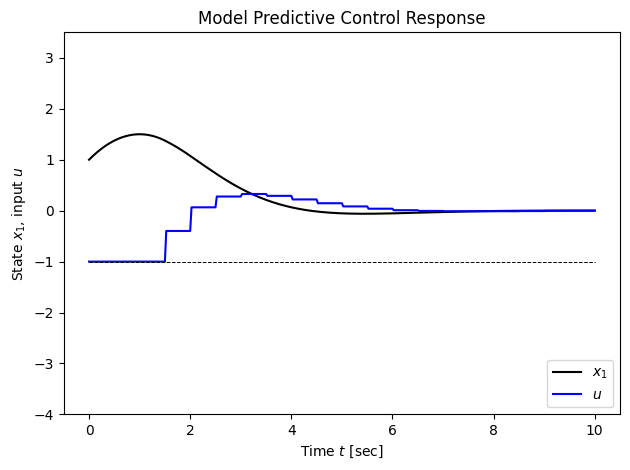

In [10]:
Tf = 10 # Total time for control
# Run the simulation
mpc_resp = run_mpc(proc, ocp, X0, Tf, verbose=True, print_summary=False)
print(f"Final state xf = {mpc_resp.states[:, -1]}")

# Plot the results
plot_mpc(mpc_resp)

**Questions to think about:**
* We used four different time in the above simulation: `timepts`, `Th`, `Tf`, and `t_seg`. Explain what are they. Try to use different values for them and see how will it affect the simulation results.
* In each step of the MPC loop, an optimal control problem is solved over the horizon `Th`. This provides an optimal input trajectory `u(t)` for `t` from 0 to `Th`. How much of this trajectory is actually applied to the plant before the optimization is performed again? What is the time step of the MPC controller?
* The terminal cost is defined by the matrix `P1`. What is the purpose of a terminal cost? What might happen to the system's final state if you set `P1` to be a zero matrix?
* Try to use the first-order hold on the input that is commented out in the above code. Explain what is different from the constant control input? Do you notice any difference on the state trajectory?

### MPC vs LQR vs LQR terminal cost

In the formulation above, we used a MPC controller with the terminal cost as $P_1 = \text{diag}(0.1, 0.1)$. An alternative is to set the terminal cost to be the LQR terminal cost that goes along with the trajectory cost, which then provides a "cost to go" that matches the LQR "cost to go" (but keeping in mind that the LQR controller does not necessarily respect the constraints for the control inputs).

The following code compares three different controllers:
1.  **MPC with `P1` terminal cost (`MPC + P1`)**: This is the original MPC controller we designed. It uses a simple quadratic terminal cost defined by `P1`. This controller solves an optimal control problem at each step to plan a trajectory over a finite horizon, explicitly considering input constraints.
2.  **Standard LQR controller (`LQR`)**: This is a linear state-feedback controller with gain `K` derived for the linearized, unconstrained system. The control law is `u = -Kx`. For the simulation, this control law is applied to the original nonlinear system, so the input is effectively saturated (`clip(-Kx)`). This controller is not predictive and does not explicitly account for constraints in its design, though it is subject to them in simulation.
3.  **MPC with LQR terminal cost (`MPC + P_lqr`)**: This MPC controller is identical to the first, but it uses the solution `P_lqr` of the algebraic Riccati equation from the corresponding LQR problem as its terminal cost. This provides a more accurate estimate of the "cost-to-go" beyond the prediction horizon, often leading to improved performance and stability.

P_lqr = 
[[1.41421356 1.        ]
 [1.         1.41421356]]


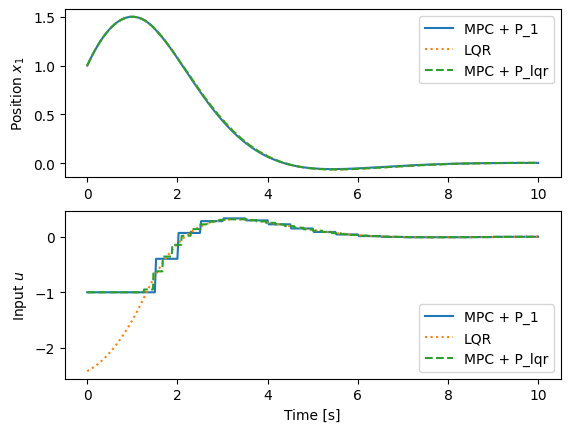

In [11]:
# Get the LQR solution
K, P_lqr, E = ctl.lqr(proc.linearize(0, 0), Qx, Qu)
print(f"P_lqr = \n{P_lqr}")

# Create an LQR controller (and run it)
lqr_ctrl, lqr_clsys = ctl.create_statefbk_iosystem(proc, K)
lqr_resp = ctl.input_output_response(lqr_clsys, mpc_resp.time, 0, X0)

# Create a new optimal control problem using the LQR terminal cost
# (need use more refined time grid as well, to approximate LQR rate)
lqr_timepts = np.linspace(0, Th, 25, endpoint=True)
lqr_term_cost=opt.quadratic_cost(proc, P_lqr, None) # here we used P_lqr instead of P1
ocp_lqr = opt.OptimalControlProblem(
    proc, lqr_timepts, traj_cost, terminal_cost=lqr_term_cost,
    trajectory_constraints=traj_constraints,
)

# Create the response for the new controller
mpc_lqr_resp = run_mpc(
    proc, ocp_lqr, X0, 10, print_summary=False)

# Plot the different responses to compare them
fig, ax = plt.subplots(2, 1)
ax[0].plot(mpc_resp.time, mpc_resp.states[0], label='MPC + P_1')
ax[0].plot(lqr_resp.time, lqr_resp.outputs[0], ':', label='LQR')
ax[0].plot(mpc_lqr_resp.time, mpc_lqr_resp.states[0], '--', label='MPC + P_lqr')
ax[0].set_ylabel('Position $x_1$')
ax[0].legend()

ax[1].plot(mpc_resp.time, mpc_resp.inputs[0], label='MPC + P_1')
ax[1].plot(lqr_resp.time, lqr_resp.outputs[2], ':', label='LQR')
ax[1].plot(mpc_lqr_resp.time, mpc_lqr_resp.inputs[0], '--', label='MPC + P_lqr')
ax[1].set_ylabel('Input $u$')
ax[1].set_xlabel('Time [s]')
ax[1].legend()

## Task 2: Discrete time MPC

Continous time MPC can generate smooth, higher-fidelity behavior at higher compute cost and with interpolation subtleties.  Many MPC control problems are solved based on a discrete time model, which is simpler, faster, and closer to how real controllers run, provided your time step is chosen well.  We show here how to implement this for the "double integrator" system, which in discrete time has the form
$$
  x[k+1] = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix} x[k] + \begin{bmatrix} 0 \\ dt \end{bmatrix} \text{clip}(u[k])
$$
where $dt$ is the time step.

Text(0.5, 1.0, 'Linearized LQR response from x0')

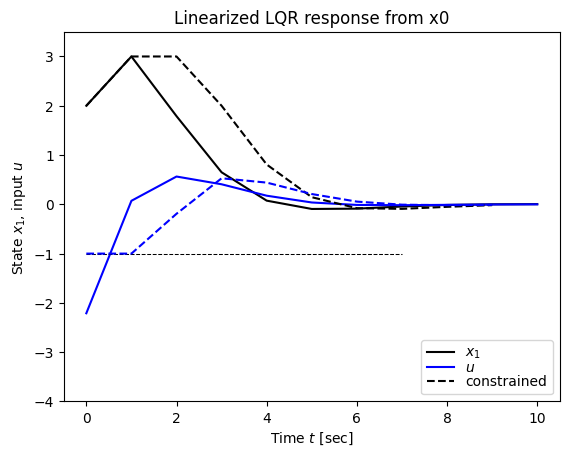

In [12]:
# System definition

def doubleint_update(t, x, u, params):
    # Get the parameters
    lb = params.get('lb', -1)
    ub = params.get('ub', 1)
    assert lb < ub

    # Get the sampling time
    dt = params.get('dt', 1)

    # bound the input
    u_clip = np.clip(u, lb, ub)

    return np.array([x[0] + dt * x[1], x[1] + dt * u_clip[0]])

proc = ctl.nlsys(
    doubleint_update, None, name="double integrator",
    inputs = ['u'], outputs=['x[0]', 'x[1]'], states=2,
    params={'dt': 1}, dt=1)

#
# Linear quadratic regulator
#

# Define the cost functions to use
Qx = np.diag([1, 0])            # matrix for state cost
Qu = np.diag([1])               # matrix for input cost
P1 = np.diag([0.1, 0.1])        # matrix for terminal cost

# Get the LQR solution
K, P, E = ctl.dlqr(proc.linearize(0, 0), Qx, Qu)

# Test out the LQR controller, with no constraints
linsys = proc.linearize(0, 0)
clsys_lin = ctl.ss(linsys.A - linsys.B @ K, linsys.B, linsys.C, 0, dt=proc.dt)

X0 = np.array([2, 1])           # initial conditions
Tf = 10                         # simulation time
res = ctl.initial_response(clsys_lin, Tf, X0=X0)

# Plot the results
plt.figure(1); plt.clf(); ax = plt.axes()
ax.plot(res.time, res.states[0], 'k-', label='$x_1$')
ax.plot(res.time, (-K @ res.states)[0], 'b-', label='$u$')

# Test out the LQR controller with constraints
clsys_lqr = ctl.feedback(proc, -K, 1)
tvec = np.arange(0, Tf, proc.dt)
res_lqr_const = ctl.input_output_response(clsys_lqr, tvec, 0, X0)

# Plot the results
ax.plot(res_lqr_const.time, res_lqr_const.states[0], 'k--', label='constrained')
#ax.plot(res_lqr_const.time, (-K @ res_lqr_const.states)[0], 'b--')
ax.plot([0, 7], [-1, -1], 'k--', linewidth=0.75)

# Compute and plot the clipped (actual) control input
u_raw_const = (-K @ res_lqr_const.states)       # controller output before clipping
u_clip_const = np.clip(u_raw_const, -1, 1)      # actual applied control
ax.plot(res_lqr_const.time, u_clip_const[0], 'b--')


# Adjust the limits for consistency
ax.set_ylim([-4, 3.5])

# Label the results
ax.set_xlabel("Time $t$ [sec]")
ax.set_ylabel("State $x_1$, input $u$")
ax.legend(loc='lower right', labelspacing=0)
plt.title("Linearized LQR response from x0")

Summary statistics:
* Cost function calls: 38
* Constraint calls: 51
* System simulations: 82
* Final cost: 29.248892708529276
* Process time: 0.042 s



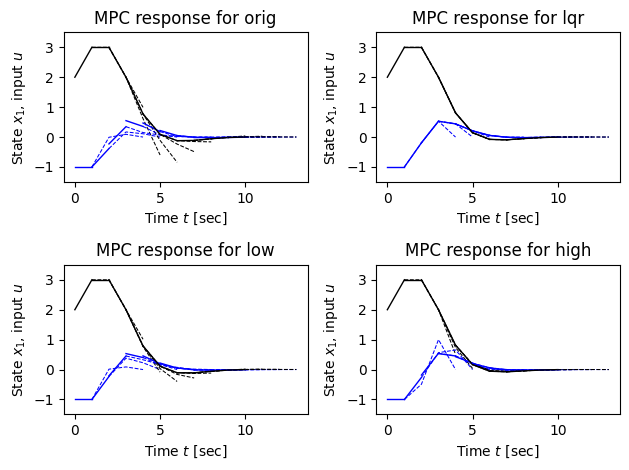

In [13]:
#
# MPC controller
#

# Create the constraints
traj_constraints = opt.input_range_constraint(proc, -1, 1)
term_constraints = opt.state_range_constraint(proc, [0, 0], [0, 0])

# Define the optimal control problem we want to solve
T = 5
timepts = np.arange(0, T * proc.dt, proc.dt)

# Set up four optimal control problems
# ocp1: the original with P1
ocp_orig = opt.OptimalControlProblem(
    proc, timepts,
    opt.quadratic_cost(proc, Qx, Qu),
    trajectory_constraints=traj_constraints,
    terminal_cost=opt.quadratic_cost(proc, P1, None),
)

# ocp2: the LQR with P
ocp_lqr = opt.OptimalControlProblem(
    proc, timepts,
    opt.quadratic_cost(proc, Qx, Qu),
    trajectory_constraints=traj_constraints,
    terminal_cost=opt.quadratic_cost(proc, P, None),
)

#ocp3: scaled down P
ocp_low = opt.OptimalControlProblem(
    proc, timepts,
    opt.quadratic_cost(proc, Qx, Qu),
    trajectory_constraints=traj_constraints,
    terminal_cost=opt.quadratic_cost(proc, P/10, None),
)

#ocp4: scaled up P
ocp_high = opt.OptimalControlProblem(
    proc, timepts,
    opt.quadratic_cost(proc, Qx, Qu),
    trajectory_constraints=traj_constraints,
    terminal_cost=opt.quadratic_cost(proc, P*10, None),
)
weight_list = [P1, P, P/10, P*10]
ocp_list = [ocp_orig, ocp_lqr, ocp_low, ocp_high]

# Do a test run to figure out how long computation takes
start_time = time.process_time()
ocp_lqr.compute_trajectory(X0)
stop_time = time.process_time()
print("* Process time: %0.2g s\n" % (stop_time - start_time))

# Create a figure to use for plotting
fig, [[ax_orig, ax_lqr], [ax_low, ax_high]] = plt.subplots(2, 2)
ax_list = [ax_orig, ax_lqr, ax_low, ax_high]
ax_name = ['orig', 'lqr', 'low', 'high']

# Generate the individual traces for the MPC control
for ocp, ax, name, Pf in zip(ocp_list, ax_list, ax_name, weight_list):
    x, t = X0, 0
    for i in np.arange(0, Tf, proc.dt):
        # Calculate the optimal trajectory
        res = ocp.compute_trajectory(x, print_summary=False)
        soln = ctl.input_output_response(proc, res.time, res.inputs, x)

        # Plot the results for this time instant
        ax.plot(res.time[:2] + t, res.inputs[0, :2], 'b-', linewidth=1)
        ax.plot(res.time[:2] + t, soln.outputs[0, :2], 'k-', linewidth=1)

        # Plot the results projected forward
        ax.plot(res.time[1:] + t, res.inputs[0, 1:], 'b--', linewidth=0.75)
        ax.plot(res.time[1:] + t, soln.outputs[0, 1:], 'k--', linewidth=0.75)

        # Update the state to use for the next time point
        x = soln.states[:, 1]
        t += proc.dt

    # Adjust the limits for consistency
    ax.set_ylim([-1.5, 3.5])

    # Label the results
    ax.set_xlabel("Time $t$ [sec]")
    ax.set_ylabel("State $x_1$, input $u$")
    ax.set_title(f"MPC response for {name}")
    plt.tight_layout()

We can also implement a MPC controller for a discrete time system using `opt.create_mpc_iosystem`.  This creates a controller that accepts the current state as the input and generates the control to apply from that state.

In [14]:
# Construct using create_mpc_iosystem
clsys = opt.create_mpc_iosystem(
    proc, timepts, opt.quadratic_cost(proc, Qx, Qu), traj_constraints,
    terminal_cost=opt.quadratic_cost(proc, P1, None),
)
print(clsys)

<NonlinearIOSystem>: sys[7]
Inputs (2): ['x[0]', 'x[1]']
Outputs (1): ['u']
States (5): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]']
dt = 1

Update: <function OptimalControlProblem.create_mpc_iosystem.<locals>._update at 0x7b6b589465c0>
Output: <function OptimalControlProblem.create_mpc_iosystem.<locals>._output at 0x7b6b589468e0>


(This function needs some work to be more user-friendly, e.g. renaming of the inputs and outputs.)

## HW Problem

### Problem: MPC for kinematic car

We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the vehicle in the plane and $\theta$ is the angle of the vehicle with respect to horizontal.  The vehicle input is given by $(v, \delta)$ where $v$ is the forward velocity of the vehicle and $\delta$ is the angle of the steering wheel.  The model includes saturation of the vehicle steering angle.

$$\begin{aligned}
  \dot x &= \cos\theta\, v \\
  \dot y &= \sin\theta\, v \\
  \dot\theta &= \frac{v}{l} \tan \delta
\end{aligned}$$

**Scenario:** A vehicle needs to perform a lane change maneuver while traveling forward. The vehicle starts in the left lane (at $y = -2$ m) and needs to move to the right lane (at $y = +2$ m) over a distance of 100 m, completing the maneuver in 10 seconds. The vehicle should maintain a constant forward velocity of 10 m/s throughout the maneuver.

**Initial and Final Conditions:**
- Initial state: $x_0 = [0, -2, 0]$ (position: origin, left lane, heading: 0°)
- Initial input: $u_0 = [10, 0]$ (velocity: 10 m/s, steering: 0 rad)
- Final state: $x_f = [100, 2, 0]$ (position: 100 m forward, right lane, heading: 0°)
- Final input: $u_f = [10, 0]$ (velocity: 10 m/s, steering: 0 rad)
- Total maneuver time: $T_f = 10$ s

Before you perform the tasks below, first generate an open‑loop optimal trajectory $x_d(t),\, u_d(t)$ for the scenario above using Lab 7 (Approach 3: input cost + terminal constraints). We will use this planned trajectory as the reference to be tracked by the MPC controller in Task 1.

**Tasks:**

Following the implementation structure used for the double integrator system in Tasks 1 and 2, implement MPC controllers for the kinematic car:

1. **Continuous-time MPC (Task 1 approach) — TRACK the given reference $x_d(t), u_d(t)$ from Lab 7:**
   - Build time-aligned interpolants for the reference over the prediction horizon:
     - Create $x_d(t)$ and $u_d(t)$ from your sampled Lab 7 trajectory using linear interpolation (first‑order hold). In Python, you can use `scipy.interpolate.interp1d(..., kind='linear', axis=1)` for states and inputs.
   - Define a tracking cost that penalizes deviation from the reference and control effort:
     - Trajectory (integral) cost: $\int_0^{T_h} (x(t)-x_d(t))^T Q_x (x(t)-x_d(t)) + (u(t)-u_d(t))^T Q_u (u(t)-u_d(t)) \, dt$.
     - Terminal cost: $(x(T_h)-x_d(T_h))^T P (x(T_h)-x_d(T_h))$.
     - You may need to use something like `traj_cost = opt.quadratic_cost(proc, Qx, Qu, x0=x_d(t), u0=u_d(t))`
   - Set input constraints consistent with the model and scenario:
     - Steering limit $|\delta| \le \delta_{\max}$ (e.g., 0.5 rad). Optionally bound velocity around 10 m/s if desired.
   - Choose a prediction horizon $T_h=5s$ and a time grid `timepts` for the OCP (e.g., with 11 grid points).
   - Create an `OptimalControlProblem` using the tracking cost and constraints.
   - Implement an MPC simulation loop (similar to `run_mpc()` from Task 1 for the double integrator).
   - Plot and report:
     - XY path: plot $(x(t), y(t))$ for the closed loop and overlay the desired path from Lab7.
     - Time histories: plot $x(t), y(t), \theta(t)$ and inputs $v(t), \delta(t)$ versus their references.

2. **Discrete-time MPC (Task 2 approach):**
   - Discretize the kinematic car model with an appropriate sampling time (e.g., $dt = 0.1$ s)
   - Define discrete-time cost functions and constraints
   - Set up the discrete-time optimal control problem
   - Implement and simulate the discrete-time MPC controller
   - Compare the continuous-time and discrete-time MPC results

In [15]:
# Code to model vehicle steering dynamics

# Function to compute the RHS of the system dynamics
def kincar_update(t, x, u, params):
    # Get the parameters for the model
    l = params['wheelbase']             # vehicle wheelbase
    deltamax = params['maxsteer']         # max steering angle (rad)

    # Saturate the steering input
    delta = np.clip(u[1], -deltamax, deltamax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(delta)      # thdot = v/l tan(delta)
    ])

kincar_params={'wheelbase': 3, 'maxsteer': 0.5}

# Create nonlinear input/output system
kincar = ctl.nlsys(
    kincar_update, None, name="kincar", params=kincar_params,
    inputs=('v', 'delta'), outputs=('x', 'y', 'theta'),
    states=('x', 'y', 'theta'))